In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pylightcurve as plc
import numpy as np


###############################################################################################
##### Create a Planet object
###############################################################################################

# At first we need to  create a Planet object.
# Planets include in the ExoClock project (https://www.exoclock.space/database/planets)
# can be loaded automatically. 
# Alteranatively we can difine our custom Planet object (see notebook: The Planet class)

planet = plc.get_planet('WASP-39b')

###############################################################################################


exoclock: Checking ephemerides database...
exoclock: Checking catalogues database...
exoclock: Checking ut database...
pylightcurve: Checking exotethys database...
pylightcurve: Checking photometry database...


<IPython.core.display.Javascript object>


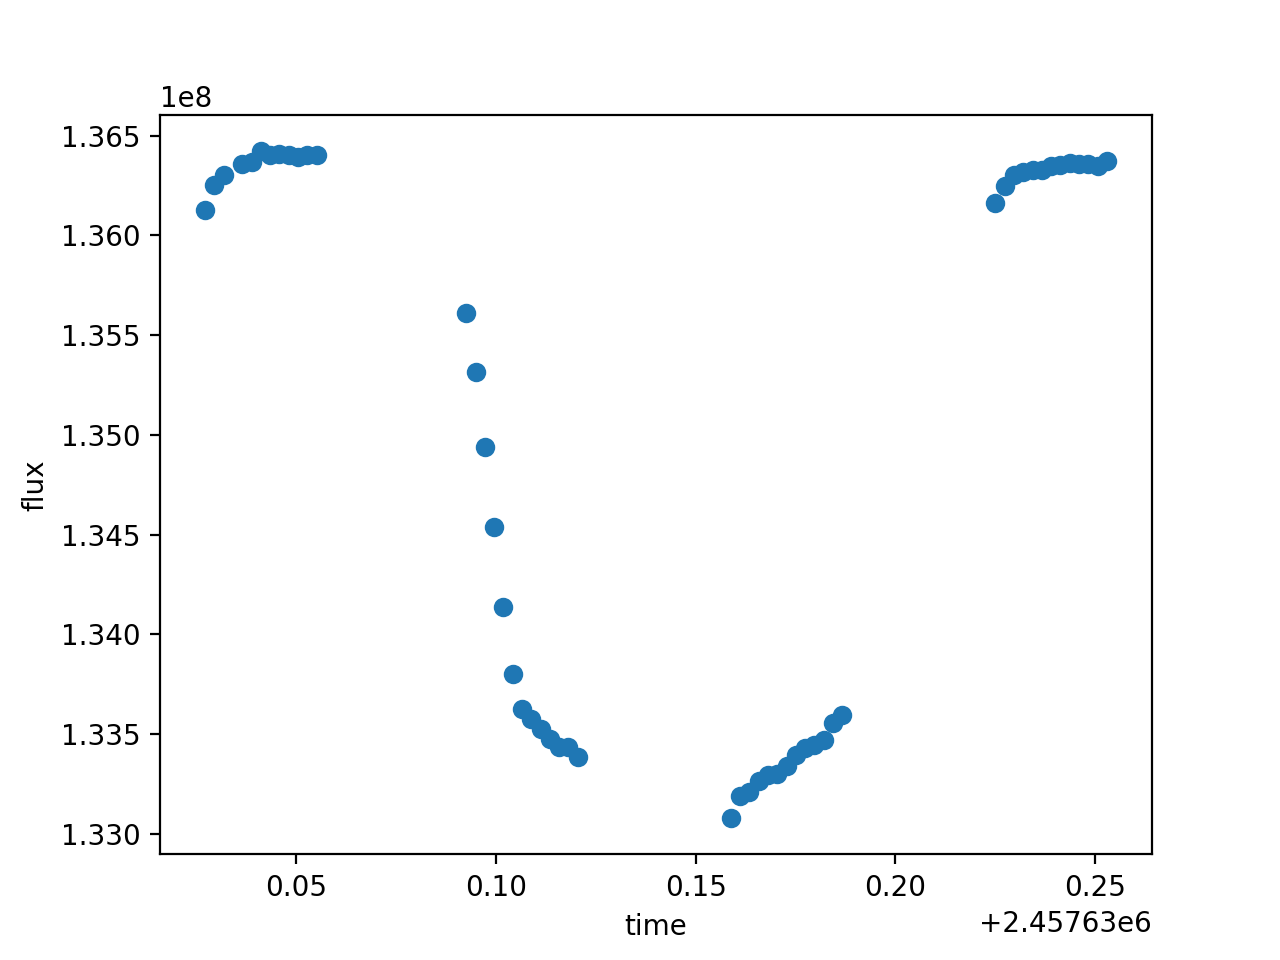

Auxiliary data available:


<IPython.core.display.Javascript object>


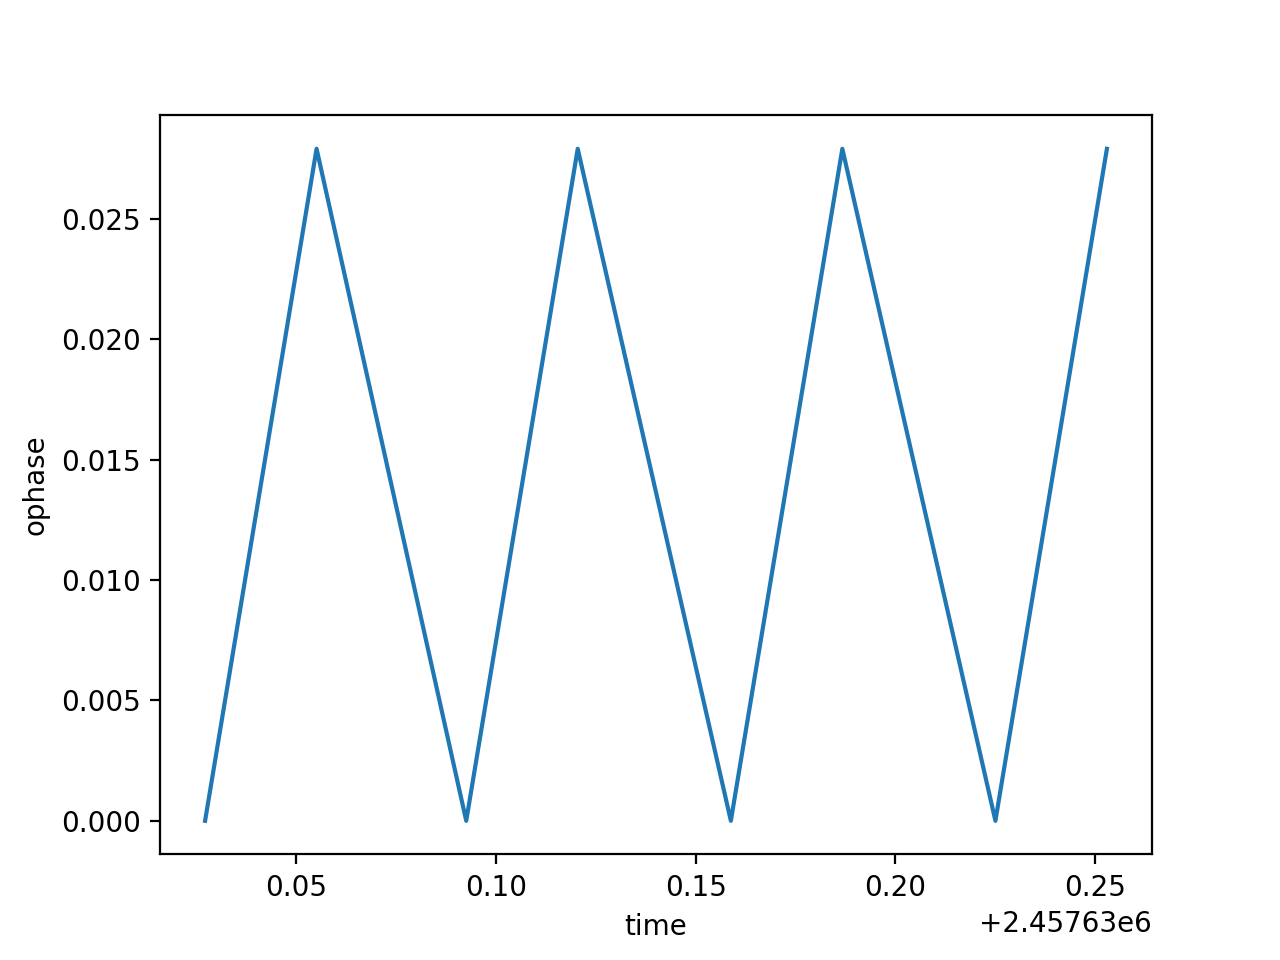

time_format: HJD_UTC
time_stamp: mid
exp_time: 134.354034
flux_format: flux
filter_name: hst_wfc3_ir_g141
wlrange: [10880.0, 16800.0]


In [2]:
###############################################################################################
##### Load data
###############################################################################################

# This dataset contains one transit observation of WASP-39b, obtained by HST/WFC3/IR/G141, 
# as part of the 14260 GO program, and analysed with Iraclis:
# https://iopscience.iop.org/article/10.3847/1538-3881/aaaf75
# It is the white light curve of the first order spectrum, 
# i.e. the sum of all the flux from 10880 to 16800 Angstrom.

data = plc.open_dict('wasp39b_hst.pickle')

###############################################################################################





###############################################################################################
##### Inspect data
###############################################################################################

# The dictionaly contains the necessary keywords:
# 'time'
# 'time_format'
# 'time_stamp'
# 'exp_time'
# 'flux'
# 'flux_unc'
# 'flux_format'
# 'filter_name'

# In addition, the dictionaly contains as auxiliary data the HST orbital phase:
# 'ophase'

plt.figure()
plt.ylabel('flux')
plt.xlabel('time')
plt.errorbar(data['time'], data['flux'], data['flux_unc'], fmt='o')

if 'auxiliary_data' in data and data['auxiliary_data']:
    print('Auxiliary data available:')
    for i in data['auxiliary_data']:
        plt.figure()
        plt.ylabel(i)
        plt.xlabel('time')
        plt.plot(data['time'], data['auxiliary_data'][i])

for i in ['time_format', 'time_stamp', 'exp_time', 'flux_format', 'filter_name', 'wlrange']:
    print('{0}: {1}'.format(i, data[i]))
    
###############################################################################################





###############################################################################################
##### Define the trend function
###############################################################################################

# By default, the detrending is done using a second order polynomial with time.
# For HST, this trend function is not sufficient and we have to define our custon trend function.
# The trendt function should take as a first argument a dictionary. This dictionary contains all
# the input series: time, airmass (if observatory location is defined) and all 
# the auxiliary time series (here the ophase).
# We need to experiment with the formula until you get a reasonalbe fit.
# Here we will use a well-established trend function for HST,
# a linear with time in the observation (time - start of the observation) 
# and an exponential with orbital phase of HST (ophase in the auxiliary data).
# We will also define the exponential decay parameter in log-space, for a better sampling of the parameters space.

def trend_function_hst(dictionary, c1, c2, c3):
    return (1.0 
            - c1 * (dictionary['time'] - min(dictionary['time']))
            - c2 * np.exp(- (10**c3) * dictionary['ophase'])
           )

data['trend_function'] = trend_function_hst



# We also need to define the prioprios for the trend function parameters. The number of rows 
# should be equal to the number of parameters. We will need to expriment with the values until 
# we get a reasonalbe fit.
# For example: 
# trend_parameters = [
#    [initial guess for c1, min value for c1, max value for c1, c1 name, c1 name for figures],
#    [initial guess for c2, min value for c2, max value for c2, c2 name, c2 name for figures],
#    [initial guess for c3, min value for c3, max value for c3, c3 name, c3 name for figures],
#    ...
# ]

trend_parameters_hst = [
    [0.01, -1, 1, 'ls', '$l_s$'],
    [0.01, -1, 1, 'sa', '$s_a$'],
    [2, 0, 5, 'sd', '$s_d$'],
]

data['trend_parameters'] = trend_parameters_hst

###############################################################################################





###############################################################################################
##### Define the stellar model
###############################################################################################

# The default stellar model used to calculate the limb-darkening coefficients 
# is the 'Pheonix_2018'. Here, we will not change this.

###############################################################################################





###############################################################################################
##### Add observation to the Planet object
###############################################################################################

# Then we are going to add the observation to the Planet object.
# It is advised to use planet.clear_observations() before, 
# to avoid duplications, in case we forget that we have already added the same observation.

planet.clear_observations()
planet.add_observation_from_dict(data)

###############################################################################################


PHOENIX models are only computed for solar metallicity stars. Setting stellar_metallicity = 0.



File already here...  teff05400_logg4.00_MH0.0.pickle
File already here...  teff05400_logg4.50_MH0.0.pickle

Observation:  obs0
Filter:  hst_wfc3_ir_g141:10880.0-16800.0
Epoch:  183
Data-points excluded:  0
Scaling uncertainties by:  1

Optimising initial parameters...
Transit fitting...


<IPython.core.display.Javascript object>


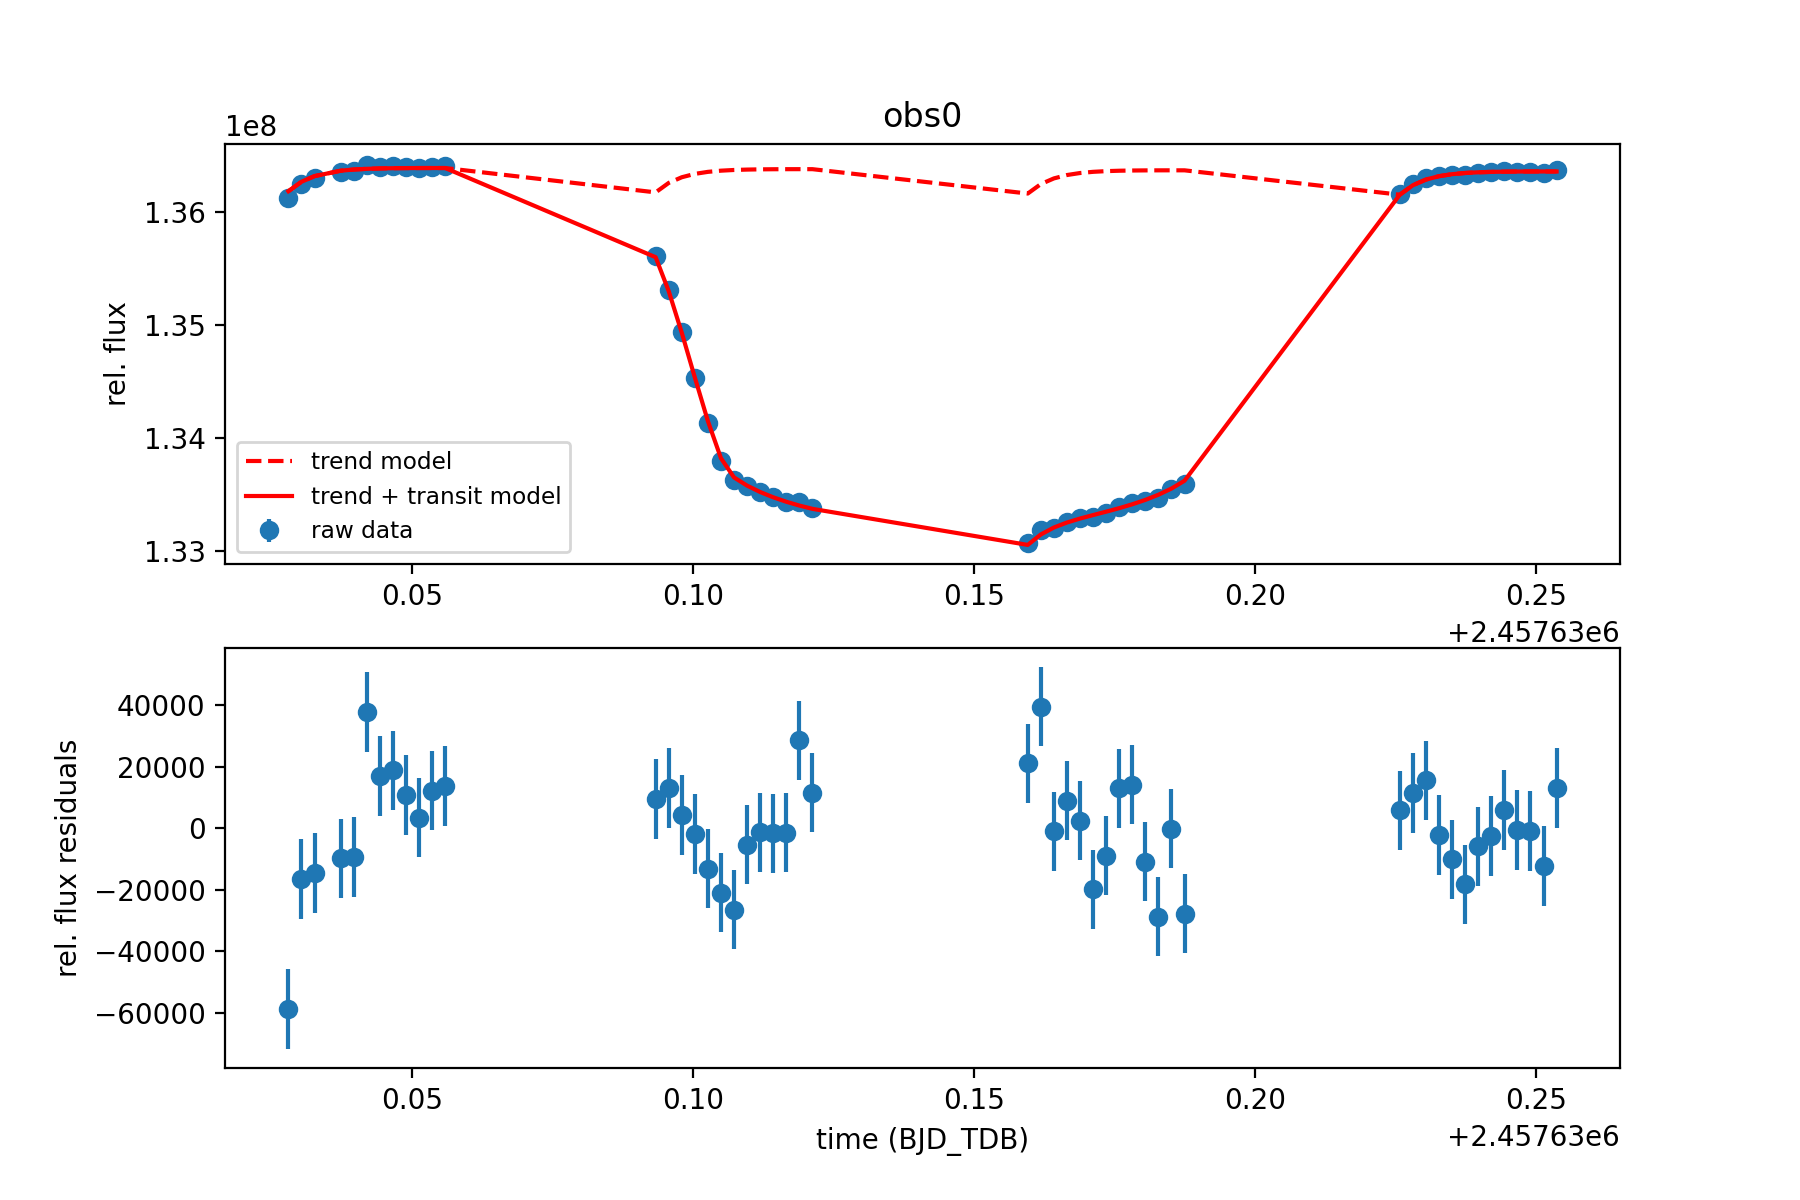


Observation:  obs0
Filter:  hst_wfc3_ir_g141:10880.0-16800.0
Epoch:  183
Number of outliers removed:  0
Uncertainties scale factor:  1
Residuals statistics:
res_max_autocorr: 	 0.37896077757966584
res_max_autocorr_flag: 	 False
res_shapiro: 		 0.9680696129798889
res_shapiro_flag: 	 False
res_mean: 		 5.4112843324740725
res_std: 		 17231.47589067632
res_rms: 		 17231.476740342292
res_chi_sqr: 		 90.75523340420631
res_red_chi_sqr: 	 1.7795143804746334


In [3]:

###############################################################################################
##### Test the performance of the trend function 
###############################################################################################

# We can test the performance of the trend function with quick fit, using: 
# optimiser = 'curve_fit'.

test = planet.transit_fitting(
    optimiser = 'curve_fit',
)

###############################################################################################





###############################################################################################
##### Evaluate test results
###############################################################################################

# To evaluate the test results we can plot the raw data, trend function, and residuals like this:

observations = len(test['observations'])
plt.figure(figsize=(9,6))
for obs_n, obs_id in enumerate(test['observations']):
    observation = test['observations'][obs_id]
    plt.subplot(2, observations, obs_n + 1)
    plt.errorbar(observation['input_series']['time'], 
                 observation['input_series']['flux'], 
                 observation['input_series']['flux_unc'], 
                 fmt='o', zorder=0, label='raw data')
    plt.plot(observation['input_series']['time'], observation['output_series']['trend'], 'r--', zorder=1, 
             label='trend model')
    plt.plot(observation['input_series']['time'], observation['output_series']['model'], 'r-', zorder=1,
             label='trend + transit model'
            )
    plt.legend(fontsize='small')
    plt.ylabel('rel. flux')
    plt.title(obs_id)

    plt.subplot(2, observations, observations + 1)
    plt.errorbar(observation['input_series']['time'], 
                 observation['output_series']['residuals'], 
                 observation['input_series']['flux_unc'], 
                 fmt='o', zorder=0)
    plt.xlabel('time (BJD_TDB)')
    plt.ylabel('rel. flux residuals')

    
    
# And also print the residuals diagnostics like this:

for obs_n, obs_id in enumerate(test['observations']):
    observation = test['observations'][obs_id]
    print('')
    print('Observation: ', obs_id)
    print('Filter: ', observation['model_info']['filter_id'])
    print('Epoch: ', observation['model_info']['epoch'])
    print('Number of outliers removed: ', observation['data_conversion_info']['outliers'])
    print('Uncertainties scale factor: ', observation['data_conversion_info']['scale_factor'])

    print('Residuals statistics:')
    print('res_max_autocorr:', '\t', observation['statistics']['res_max_autocorr'])
    print('res_max_autocorr_flag:', '\t', observation['statistics']['res_max_autocorr_flag'])
    print('res_shapiro:', '\t\t', observation['statistics']['res_shapiro'])
    print('res_shapiro_flag:', '\t', observation['statistics']['res_shapiro_flag'])
    print('res_mean:', '\t\t', observation['statistics']['res_mean'])
    print('res_std:', '\t\t', observation['statistics']['res_std'])
    print('res_rms:', '\t\t', observation['statistics']['res_rms'])
    print('res_chi_sqr:', '\t\t', observation['statistics']['res_chi_sqr'])
    print('res_red_chi_sqr:', '\t', observation['statistics']['res_red_chi_sqr'])
    
###############################################################################################


In [4]:

###############################################################################################
##### MCMC fit
###############################################################################################

# If the residuals diagniostics look ok, we can run the MCMC.
# Here we will define the 'output_folder', so that all the results and plots are saved.
# We don't need to defile the optimiser, as the default one is 'mcmc'.
# It is also better to use filter_outliers=True to clear the outliers and 
# and scale_uncertainties=True to scale the errorbars to match the residuals rms.

final = planet.transit_fitting(
    output_folder = 'wasp39b_hst',
    filter_outliers=True,
    scale_uncertainties=True,
)

# By default, the number of iterations is 5000 and the burn in is 1000.
# If the chains do not converge, we can increase these number, for example by setting:
# iterations = 10000
# burn_in = 5000

###############################################################################################



Observation:  obs0
Filter:  hst_wfc3_ir_g141:10880.0-16800.0
Epoch:  183
Data-points excluded:  1
Scaling uncertainties by:  1.112082018435905

Optimising initial parameters...
Transit fitting: 5000 / 5000 , time left: 0:00:00, time elapsed: 0:02:33, total time: 0:02:33
